# Gold: Serve data
One could argue that this is also a kind of transformation. The main purpose of the Gold-Lazyer is to aggregated data and to prepare the data for serving (API, Reporting, ...)

  temperature_category  count   avg_temp  avg_humidity  avg_wind_speed
0                 Mild     59  16.535593     82.559322        6.466102
1                 Warm     37  23.154054     64.891892        4.310811


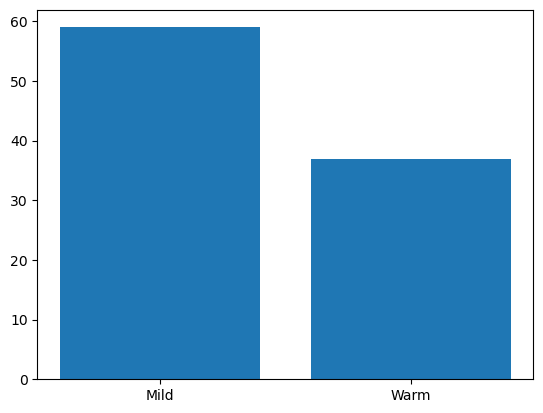

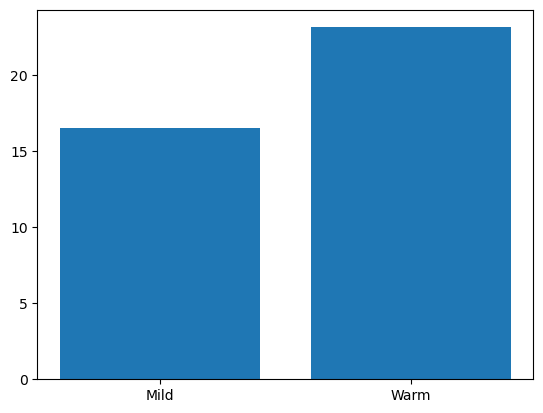

Aggregated data stored in MinIO at gold/weather_aggregated.parquet


In [1]:
import duckdb
import boto3
import pandas as pd
from io import BytesIO

# MinIO Configuration
# -------------------------------------------------------------------------------------------------
MINIO_ENDPOINT = "http://minio:9000"
# Danger-Zone (https://www.youtube.com/watch?v=siwpn14IE7E)
# Typicalla a kind of vault would be used e.g. https://azure.microsoft.com/en-us/products/key-vault, ...
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "password"
BUCKET_NAME = "weather-data"
SILVER_FILE_NAME = "silver/weather_cleaned.parquet"
GOLD_FILE_NAME = "gold/weather_aggregated.parquet"

# Initialize MinIO Client
s3 = boto3.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    aws_access_key_id=MINIO_ACCESS_KEY,
    aws_secret_access_key=MINIO_SECRET_KEY
)

# Load Transformed Data from MinIO
silver_obj = s3.get_object(Bucket=BUCKET_NAME, Key=SILVER_FILE_NAME)
df_transformed = pd.read_parquet(BytesIO(silver_obj["Body"].read()))

# Register in DuckDB and perform Aggregations
conn = duckdb.connect(database=":memory:")
conn.register("weather_data", df_transformed)

df_aggregated = conn.execute("""
    SELECT 
        temperature_category,
        COUNT(*) AS count,
        AVG(temperature) AS avg_temp,
        AVG(humidity) AS avg_humidity,
        AVG(wind_speed) AS avg_wind_speed
    FROM weather_data
    GROUP BY temperature_category
""").fetchdf()

# Save aggregated data to MinIO
parquet_buffer = BytesIO()
df_aggregated.to_parquet(parquet_buffer, engine="pyarrow")
s3.put_object(Bucket=BUCKET_NAME, Key=GOLD_FILE_NAME, Body=parquet_buffer.getvalue())

# Display Aggregated Data

print(df_aggregated)

from matplotlib import pyplot as plt 
x = df_aggregated['temperature_category'].tolist()
y = df_aggregated['count'].tolist()
plt.bar(x, y)
plt.show()

y = df_aggregated['avg_temp'].tolist()
plt.bar(x, y)
plt.show()

print(f"Aggregated data stored in MinIO at {GOLD_FILE_NAME}")